# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay,
    roc_auc_score,
)

from xgboost import XGBClassifier
from catboost import CatBoostClassifier

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Preparing Data

## Loading Data

In [2]:
train = pd.read_csv("/kaggle/input/celestialclassify/train.csv")
test = pd.read_csv("/kaggle/input/celestialclassify/test.csv")

## Replace NaNs

In [3]:
train["rowv"].replace(-9999, np.nan, inplace=True)
train["rowv"].fillna(train["rowv"].mean(), inplace=True)
print(train["rowv"].isnull().sum())

test["colv"].replace(-9999, np.nan, inplace=True)
test["colv"].fillna(test["colv"].mean(), inplace=True)
print(test["colv"].isnull().sum())

0
0


## Standardizing and Creating Train and Test Sets

In [4]:
X_train = train.drop("type", axis=1)
y_train = train["type"]
del train
gc.collect()
X_test = test.drop("type", axis = 1)
y_test = test["type"]
del test
gc.collect()

0

In [5]:
y_train = y_train.apply(lambda x: 1 if x=="star" else 0)
y_test = y_test.apply(lambda x: 1 if x=="star" else 0)

In [6]:
scalar = StandardScaler()

X_train = scalar.fit_transform(X_train)
X_test = scalar.transform(X_test)

## Some Functions to Evaluate Models

In [7]:
def cm_to_metrics(cm):
    """Calculate accuracy, precision, recall and f1 score from confusion matrix.
    
    Parameters
    ----------
    cm : array-like
        Confusion matrix.
    
    Returns
    -------
    accuracy : float
        Accuracy score.
    precision : float
        Precision score.
    recall : float
        Recall score.
    f1 : float
        F1 score.
    """
    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * (precision * recall) / (precision + recall)
    return accuracy, precision, recall, f1

def evaluate_model(
    model,
    on="train",
    plot_cmat=False,
    verbose=True,
):
    """
    This function evaluates a model and returns the metrics.
    It can be used to evaluate the model on the training set or the test set.
    It can also plot the confusion matrix.
    Parameters
    ----------
    model : object
        The model to be evaluated.
    on : str, optional
        The set on which the model will be evaluated. The default is "train".
    plot_cmat : bool, optional
        Whether to plot the confusion matrix. The default is False.
    verbose : bool, optional
        Whether to print the metrics. The default is True.

    Returns
    -------
    result : dict
        A dictionary with the metrics.
    
    Example
    -------
    >>> result = evaluate_model(model)
    >>> print(result)
    {'accuracy': 0.8, 'precision': 0.8, 'recall': 0.8, 'f1': 0.8, 'auc': 0.8}
    
    >>> result = evaluate_model(model, on="test")
    >>> print(result)
    {'accuracy': 0.8, 'precision': 0.8, 'recall': 0.8, 'f1': 0.8, 'auc': 0.8}
    
    >>> result = evaluate_model(model, plot_cmat=True)
    >>> print(result)
    {'accuracy': 0.8, 'precision': 0.8, 'recall': 0.8, 'f1': 0.8, 'auc': 0.8}
    
    >>> result = evaluate_model(model, on="test", plot_cmat=True)
    >>> print(result)
    {'accuracy': 0.8, 'precision': 0.8, 'recall': 0.8, 'f1': 0.8, 'auc': 0.8}
    """
    if on == "train":
        X = X_train
        y = y_train
    else:
        X = X_test
        y = y_test
    y_pred = model.predict(X)
    cm = confusion_matrix(y, y_pred)
    accuracy, precision, recall, f1 = cm_to_metrics(cm)
    auc_score = roc_auc_score(y, y_pred)

    if plot_cmat:
        disp = ConfusionMatrixDisplay(
            confusion_matrix=cm, display_labels=["star", "galaxy"]
        )
        disp.plot()
        plt.show()
    if verbose:
        try:
            model_name = model.__class__.__name__
        except:
            model_name = ""
        print(f"Accuracy on {on} set of the model {model_name}: {accuracy:.4f}")
        print(f"Precision on {on} set of the model {model_name}: {precision:.4f}")
        print(f"Recall on {on} set of the model {model_name}: {recall:.4f}")
        print(f"F1 on {on} set of the model {model_name}: {f1:.4f}")
        print(f"AUC on {on} set of the model {model_name}: {auc_score:.4f}\n")
        cr = classification_report(y, y_pred)
        print(cr)
    result = {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "auc": auc_score,
    }
    return result

# The Models

The goal was to create an ensemble of four models:

1. Support Vector Machine
2. Random Forest
3. XGBClassifier
4. CatBoostClassifier

However, as dataset is huge, training first two models started to become infeasible, especially because we can not use these two `sklearn` models to train on GPU. So, we decided to train only the last two models. These two models can be trained on GPU and are also very fast.

> I tried using some alternatives for `sklearn`'s `SVC` and `RandomForestClassifier` which can be trained on GPU, but was not completely successful. In future, I will try to train these models on GPU and add them to the ensemble. For now, I will use just the last two models.

Here are the best parameters for the models after hyperparameter tuning:

In [ ]:
# svc_best_params = {
#     "C": 16296.601892646648,
#     "gamma": 0.0011879874407358082,
#     "kernel": "rbf",
#     "degree": 2,
#     "coef0": 61.32196047340159,
# }

# rf_best_params = {
#     "n_estimators": 76,
#     "max_depth": 19,
#     "min_samples_split": 10,
#     "min_samples_leaf": 2,
#     "max_features": "sqrt",
#     "max_samples": 1.0,
# }

xgb_best_params = {
    "n_estimators": 188,
    "max_depth": 17,
    "learning_rate": 0.08245844777734937,
    "subsample": 0.9,
    "reg_alpha": 0.16634334643800422,
    "reg_lambda": 0.010449329514317554,
    "gamma": 3.5712964675328855e-05,
    "min_child_weight": 17,
}

catb_best_params = {
    "n_estimators": 198,
    "max_depth": 10,
    "learning_rate": 0.009814179840225703,
    "subsample": 0.8,
    "reg_lambda": 0.7960086364994374,
    "min_child_samples": 3,
    "max_bin": 255,
}


## XGBoost

Let's train and evaluate the `XGBClassifier` model:

In [9]:
xgbc = XGBClassifier(tree_method='gpu_hist', **xgb_best_params)
xgbc.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=3.5712964675328855e-05, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.08245844777734937, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=17, max_leaves=None,
              min_child_weight=17, missing=nan, monotone_constraints=None,
              n_estimators=188, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

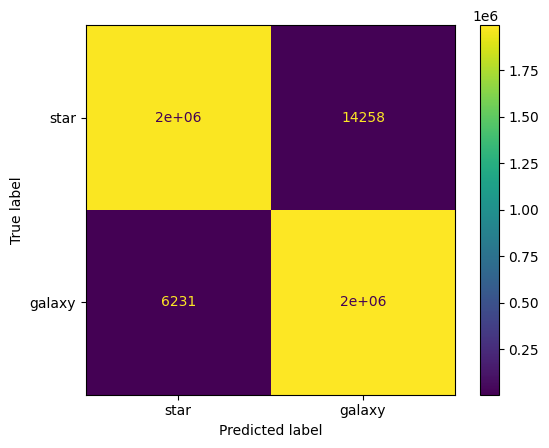

Accuracy on train set of the model XGBClassifier: 0.9949
Precision on train set of the model XGBClassifier: 0.9929
Recall on train set of the model XGBClassifier: 0.9969
F1 on train set of the model XGBClassifier: 0.9949
AUC on train set of the model XGBClassifier: 0.9949

              precision    recall  f1-score   support

           0       1.00      0.99      0.99   1999996
           1       0.99      1.00      0.99   2000004

    accuracy                           0.99   4000000
   macro avg       0.99      0.99      0.99   4000000
weighted avg       0.99      0.99      0.99   4000000



{'accuracy': 0.99487775,
 'precision': 0.9928995120095258,
 'recall': 0.9968845062309876,
 'f1': 0.9948880186924516,
 'auc': 0.9948777459864795}

In [10]:
evaluate_model(
    xgbc,
    on="train",
    plot_cmat=True,
    verbose=True,)

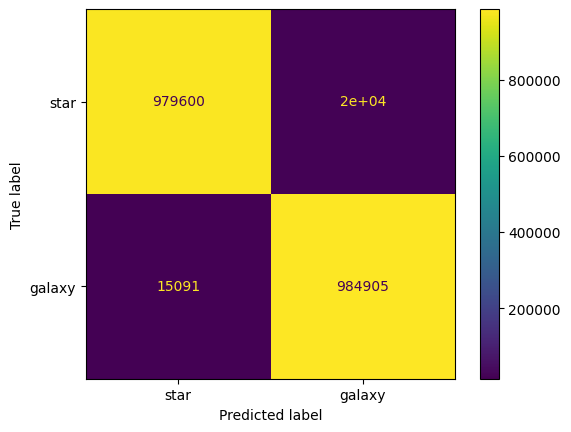

Accuracy on test set of the model XGBClassifier: 0.9823
Precision on test set of the model XGBClassifier: 0.9797
Recall on test set of the model XGBClassifier: 0.9849
F1 on test set of the model XGBClassifier: 0.9823
AUC on test set of the model XGBClassifier: 0.9823

              precision    recall  f1-score   support

           0       0.98      0.98      0.98   1000004
           1       0.98      0.98      0.98    999996

    accuracy                           0.98   2000000
   macro avg       0.98      0.98      0.98   2000000
weighted avg       0.98      0.98      0.98   2000000



{'accuracy': 0.9822525,
 'precision': 0.9797037527765096,
 'recall': 0.9849089396357585,
 'f1': 0.9822994507069996,
 'auc': 0.9822525106257161}

In [11]:
evaluate_model(
    xgbc,
    on="test",
    plot_cmat=True,
    verbose=True,)

In [12]:
xgbc_score = xgbc.score(X_test, y_test)
print(xgbc_score)

0.9822525


We can see that the model is performing quite good. It has a test accuracy of over 98%!

## CatBoost

Here are the best parameters for the `CatBoostClassifier` model:

> We have to change `bootstrap_type="Poisson"` as the default value of `bootstrap_type` is `Bayesian`. And, `Bayesian` is not supported for GPU training.

In [13]:
ctbc = CatBoostClassifier(task_type='GPU', bootstrap_type="Poisson", **catb_best_params)
ctbc.fit(X_train, y_train, verbose = True)

0:	learn: 0.6634077	total: 72.4ms	remaining: 14.3s
1:	learn: 0.6350319	total: 135ms	remaining: 13.2s
2:	learn: 0.6078244	total: 196ms	remaining: 12.8s
3:	learn: 0.5815051	total: 257ms	remaining: 12.5s
4:	learn: 0.5570651	total: 328ms	remaining: 12.6s
5:	learn: 0.5341756	total: 389ms	remaining: 12.4s
6:	learn: 0.5120580	total: 451ms	remaining: 12.3s
7:	learn: 0.4923606	total: 514ms	remaining: 12.2s
8:	learn: 0.4724300	total: 578ms	remaining: 12.1s
9:	learn: 0.4530381	total: 642ms	remaining: 12.1s
10:	learn: 0.4352311	total: 706ms	remaining: 12s
11:	learn: 0.4181942	total: 767ms	remaining: 11.9s
12:	learn: 0.4023426	total: 831ms	remaining: 11.8s
13:	learn: 0.3872076	total: 893ms	remaining: 11.7s
14:	learn: 0.3730885	total: 955ms	remaining: 11.6s
15:	learn: 0.3593352	total: 1.02s	remaining: 11.6s
16:	learn: 0.3463586	total: 1.08s	remaining: 11.5s
17:	learn: 0.3340638	total: 1.14s	remaining: 11.4s
18:	learn: 0.3229557	total: 1.21s	remaining: 11.4s
19:	learn: 0.3122961	total: 1.27s	remainin

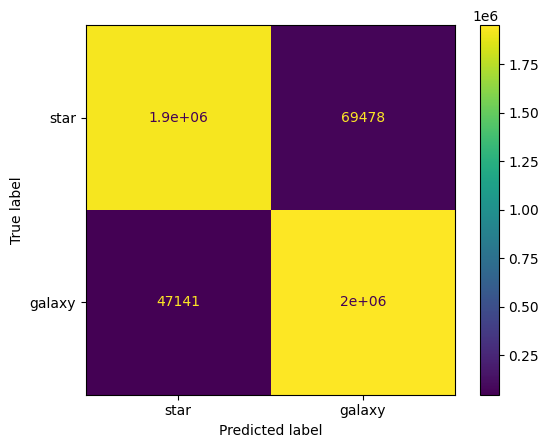

Accuracy on train set of the model CatBoostClassifier: 0.9708
Precision on train set of the model CatBoostClassifier: 0.9656
Recall on train set of the model CatBoostClassifier: 0.9764
F1 on train set of the model CatBoostClassifier: 0.9710
AUC on train set of the model CatBoostClassifier: 0.9708

              precision    recall  f1-score   support

           0       0.98      0.97      0.97   1999996
           1       0.97      0.98      0.97   2000004

    accuracy                           0.97   4000000
   macro avg       0.97      0.97      0.97   4000000
weighted avg       0.97      0.97      0.97   4000000



{'accuracy': 0.97084525,
 'precision': 0.965644765150882,
 'recall': 0.9764295471409057,
 'f1': 0.9710072109677315,
 'auc': 0.9708452388313833}

In [14]:
evaluate_model(
    ctbc,
    on="train",
    plot_cmat=True,
    verbose=True,)

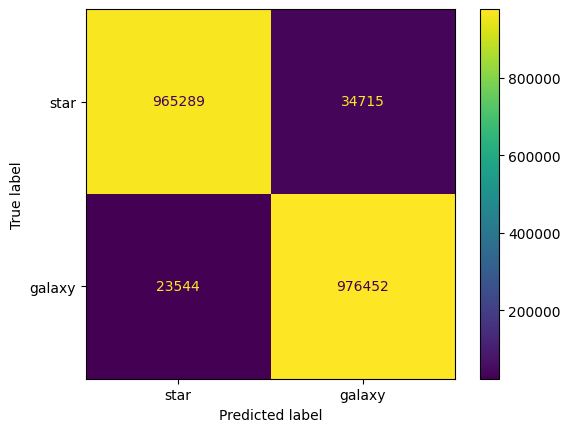

Accuracy on test set of the model CatBoostClassifier: 0.9709
Precision on test set of the model CatBoostClassifier: 0.9657
Recall on test set of the model CatBoostClassifier: 0.9765
F1 on test set of the model CatBoostClassifier: 0.9710
AUC on test set of the model CatBoostClassifier: 0.9709

              precision    recall  f1-score   support

           0       0.98      0.97      0.97   1000004
           1       0.97      0.98      0.97    999996

    accuracy                           0.97   2000000
   macro avg       0.97      0.97      0.97   2000000
weighted avg       0.97      0.97      0.97   2000000



{'accuracy': 0.9708705,
 'precision': 0.9656683811872816,
 'recall': 0.9764559058236233,
 'f1': 0.9710321838657532,
 'auc': 0.9708705223415339}

In [15]:
evaluate_model(
    ctbc,
    on="test",
    plot_cmat=True,
    verbose=True,)

In [16]:
ctbc_score = ctbc.score(X_test, y_test)
print(ctbc_score)

0.9708705


Catboost also performs quite well. It has a test accuracy of over 97%! Though, it is slightly worse than XGBoost.

# Creating Ensemble

Let's create an ensemble of these models and see how it performs:

> Note that right now we have just two models in the ensemble and hence the ensemble might not perform that well. In the future, we will add other models to the ensemble and see how it performs.

In [17]:
def evaluate_ensemble(models, X, y, voting="soft"):
    """
    Evaluates an ensemble of models on a given dataset.

    Parameters:
    models (list): A list of trained models to evaluate.
    X (array-like): The input data to evaluate the models on.
    y (array-like): The target labels for the input data.
    voting (str): The type of voting to use for the ensemble. Can be "soft" or "hard".

    Returns:
    preds (array-like): The predicted labels for the input data.
    acc (float): The accuracy of the ensemble prediction.
    """
    # Initialize an array to store the predictions for each model
    preds = np.zeros((len(models), len(X)))

    # Make predictions for each model
    for i, model in tqdm(enumerate(models), "Predicting..."):
        if voting == "soft":
            preds[i] = model.predict_proba(X)[:, 1]
        else:
            preds[i] = model.predict(X)

    # Compute the ensemble prediction based on the voting type
    preds = np.round(np.mean(preds, axis=0))

    # Compute the accuracy of the ensemble prediction
    acc = np.mean(preds == y)

    return preds, acc

In [18]:
models = [xgbc, ctbc]
soft_preds, soft_score = evaluate_ensemble(models, X_test, y_test, "soft")
hard_preds, hard_score = evaluate_ensemble(models, X_test, y_test, "hard")

Predicting...: 2it [00:29, 14.53s/it]
Predicting...: 2it [00:29, 14.77s/it]


In [19]:
print(f"XGBoost: {xgbc_score} | Catboost: {ctbc_score} | Soft Ensemble: {soft_score} | Hard Ensemble {hard_score}")

XGBoost: 0.9822525 | Catboost: 0.9708705 | Soft Ensemble: 0.9803985 | Hard Ensemble 0.9771195


It looks like XGBoost alone is giving the most accurate result! No surprise there, as it is the best model in the ensemble and we have just two models in the ensemble.